In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import fnmatch
import statsmodels.api as sm
import os.path as path
from sys import path as syspath

syspath.append('../src/')

from analysis_pipeline import Analysis
from figure_utils import save_figure
from scipy.stats import chisquare, pearsonr, shapiro, normaltest, kstest, norm, sem
from markov_utils import bin_data, bin_clip_func
from distance_utils import create_dynamic_events_matrix, create_persistent_synapse_matrix
from markov_utils import markov_pipeline, run_chain, compute_stationary_dist, get_stationary_arr

from kesten_utils import linear_regress, run_kesten

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'

from my_colormaps import viridis

%load_ext autoreload
%autoreload 2

# Preprocessing

Load and bin weights, fit Markov chain by initializing the `Analysis` object

In [2]:
# Load weights
pyr_weights = np.load(os.path.expanduser('../data/weight_matrices/quantile_4060_pyr.npz'))
pv_weights = np.load(os.path.expanduser('../data/weight_matrices/quantile_4060_pv.npz'))
pyr_dendrite_map = np.load(os.path.expanduser('../data/weight_matrices/pyr_map.npz'))
pv_dendrite_map = np.load(os.path.expanduser('../data/weight_matrices/pv_map.npz'))

# 20 bin version
bins_touse=40
bin_clip_idx=20
# Custom bin the weights to avoid fitting Markov chain and failing to do so in the uniform bin case
pyr_bins_orig = bin_data(pyr_weights,
                    bins_touse=bins_touse,
                    plot_hist=False,
                    only_nonzero=True,
                    bin_per_day=False)
pyr_bins_clip = bin_clip_func(pyr_bins_orig, bin_clip_idx=bin_clip_idx)

pv_bins_orig = bin_data(pv_weights,
                    bins_touse=bins_touse,
                    plot_hist=False,
                    only_nonzero=True,
                    bin_per_day=False)
pv_bins_clip = bin_clip_func(pv_bins_orig, bin_clip_idx=bin_clip_idx)

# Fit markov chain objects using equal bins in the range
Pyr_Control = Analysis(cell_type='pyr',
                       input_weight_matrix=pyr_weights,
                       condition='control',
                       markov_kwargs={'bins_touse': pyr_bins_clip},
                       bin_kwargs={'equal_bins': False}) # so it does not repeat the bins_touse kwarg

PV_Control = Analysis(cell_type='pv',
                      input_weight_matrix=pv_weights,
                      condition='control',
                       markov_kwargs={'bins_touse': pv_bins_clip},
                       bin_kwargs={'equal_bins': False}) # so it does not repeat the bins_touse kwarg

# Binned distribution of first day weights
pyr_start_dist = get_stationary_arr(compute_stationary_dist(intensity_mat=np.expand_dims(pyr_weights[:, 0], axis=-1), 
                                            bins_touse=Pyr_Control.markov_out['bins_touse'])[0])
pyr_start_dist = np.divide(pyr_start_dist, np.sum(pyr_start_dist))
pv_start_dist = get_stationary_arr(compute_stationary_dist(intensity_mat=np.expand_dims(pv_weights[:, 0], axis=-1), 
                                           bins_touse=PV_Control.markov_out['bins_touse'])[0])
pv_start_dist = np.divide(pv_start_dist, np.sum(pv_start_dist))

../src/markov_utils.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  analytic_stationary_dist = analytic_stationary_dist.astype('float64')


Bootstrap Markov bins [ 0.04976467  0.37451627  0.69926787  1.02401948  1.34877108  1.67352268
  1.99827429  2.32302589  2.64777749  2.9725291   3.2972807   3.6220323
  3.94678391  4.27153551  4.59628711  4.92103871  5.24579032  5.57054192
  5.89529352  6.22004513 13.03982879]
Preprocessed intensity
Total 3281, Num Bins 20.884848484848487
Bootstrap Markov bins [0.1299294  0.26432    0.3987106  0.5331012  0.6674918  0.8018824
 0.93627301 1.07066361 1.20505421 1.33944481 1.47383541 1.60822601
 1.74261661 1.87700721 2.01139782 2.14578842 2.28017902 2.41456962
 2.54896022 2.68335082 5.50555345]


../src/markov_utils.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  analytic_stationary_dist = analytic_stationary_dist.astype('float64')


Preprocessed intensity
Total 2482, Num Bins 20.856


<Figure size 720x576 with 0 Axes>

# Figure 4C-H,K

Demonstrating the effectiveness of our very general model with very few assumptions: The underlying synaptic changes across cell types are Markovian (and we can estimate its stationary distribution), multiplicative, but have different turnover rates.

../src/markov_utils.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  analytic_stationary_dist = analytic_stationary_dist.astype('float64')


Preprocessed intensity
Total 3281, Num Bins 20.884848484848487


../src/markov_utils.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  analytic_stationary_dist = analytic_stationary_dist.astype('float64')


Preprocessed intensity
Total 2482, Num Bins 20.856


../src/markov_utils.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  analytic_stationary_dist = analytic_stationary_dist.astype('float64')


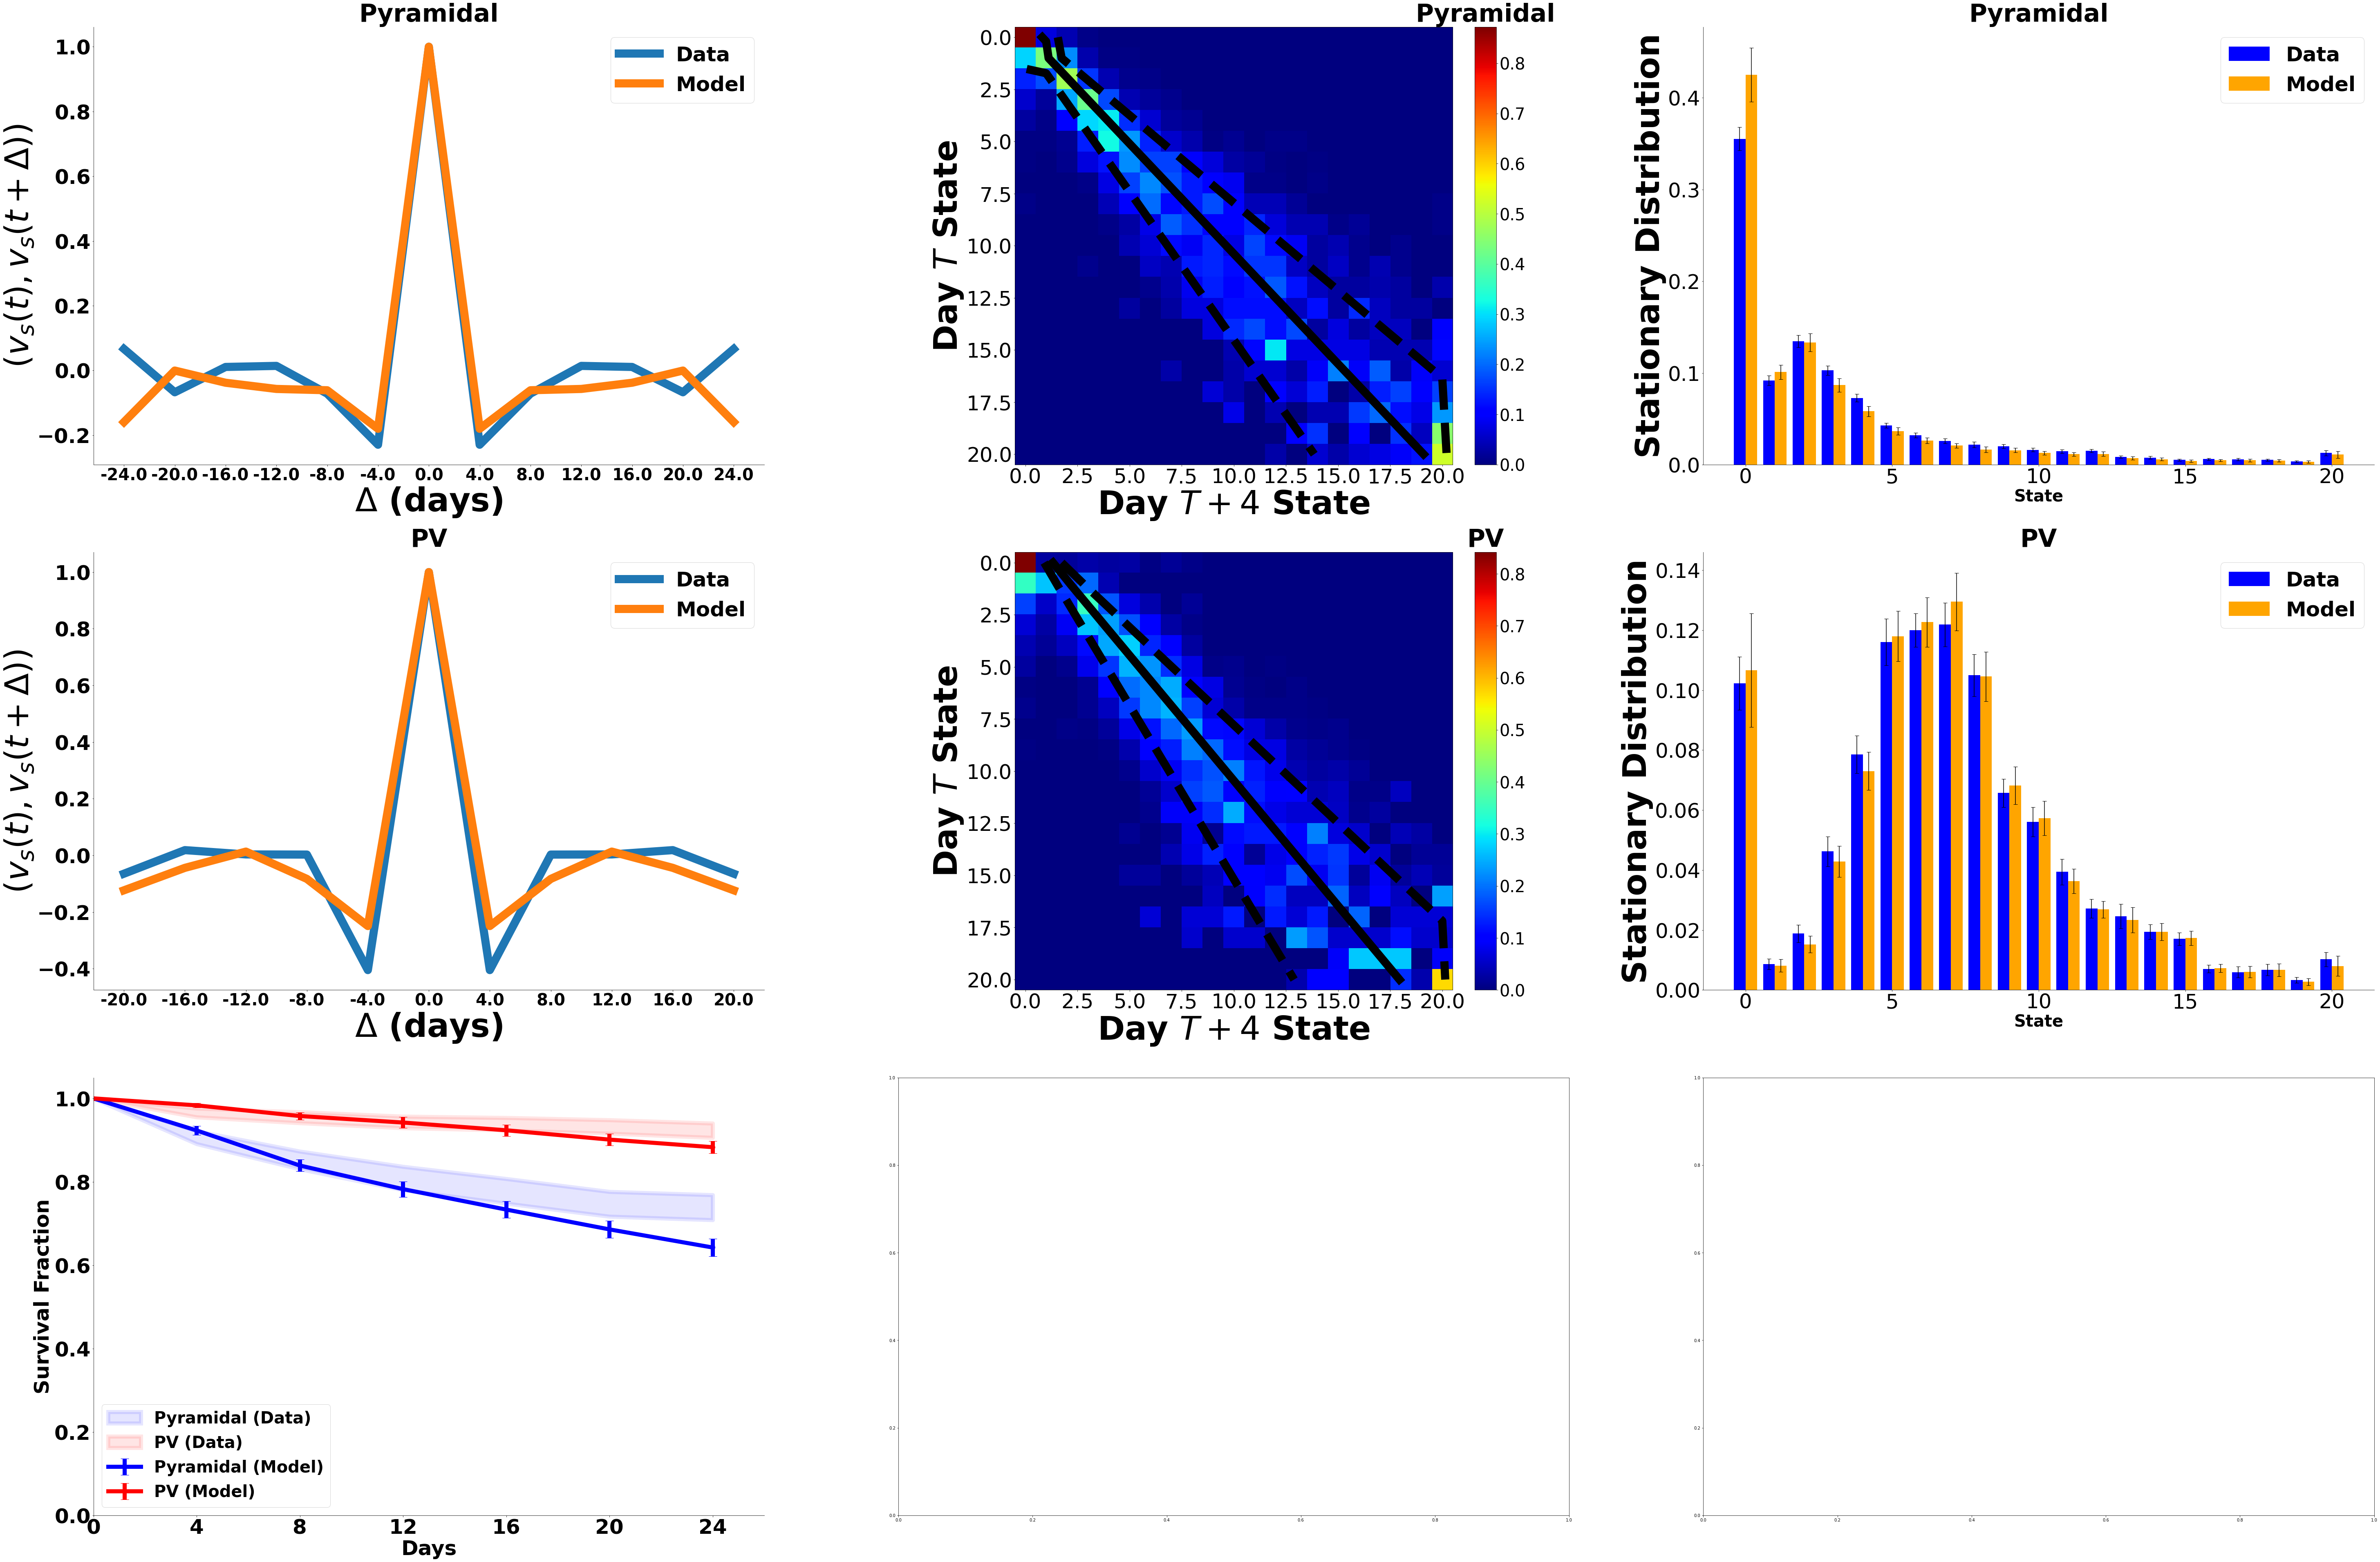

In [3]:
num_rows = 3
num_cols = 3
lw = 20
title_size=60
scale_factor = 2.0
fig, ax = plt.subplots(num_rows,num_cols, figsize=(100, 67))

ax = plt.subplot(num_rows,num_cols,1)
Pyr_Control.simulate_markov_chain()
Pyr_Control.plot_velocity(ax=ax, standalone_fig=False, lw=lw, scale_factor=scale_factor, peak_normalize=True)
plt.title('Pyramidal', weight='bold', size=title_size)

ax = plt.subplot(num_rows,num_cols,2)
Pyr_Control.plot_conditional_mat(fig=fig, ax=ax, standalone_fig=False, cmap=plt.get_cmap('jet'), scale_factor=scale_factor)
Pyr_Control.overlay_kesten_markov_states()
ax.plot(Pyr_Control.kesten_mean_y_below_1std, Pyr_Control.kesten_x_cont, color='k', linestyle='--', linewidth=lw)
ax.plot(Pyr_Control.kesten_mean_y, Pyr_Control.kesten_x_cont, color='k', linewidth=lw)
ax.plot(Pyr_Control.kesten_mean_y_above_1std, Pyr_Control.kesten_x_cont, color='k', linestyle='--', linewidth=lw)
plt.title('Pyramidal', weight='bold', size=title_size)

ax = plt.subplot(num_rows,num_cols,3)
Pyr_Control.plot_stationary_vs_empirical(ax=ax, standalone_fig=False, xtick_ub=50.25, xtick_factor=5, scale_factor=scale_factor)
plt.title('Pyramidal', weight='bold', size=title_size)

ax = plt.subplot(num_rows,num_cols,4)
PV_Control.simulate_markov_chain()
PV_Control.plot_velocity(ax=ax, standalone_fig=False, lw=lw, scale_factor=scale_factor, peak_normalize=True)
plt.title('PV', weight='bold', size=title_size)

ax = plt.subplot(num_rows,num_cols,5)
PV_Control.plot_conditional_mat(fig=fig, ax=ax, standalone_fig=False, cmap=plt.get_cmap('jet'), scale_factor=scale_factor)
PV_Control.overlay_kesten_markov_states()
ax.plot(PV_Control.kesten_mean_y_below_1std, PV_Control.kesten_x_cont, color='k', linestyle='--', linewidth=lw)
ax.plot(PV_Control.kesten_mean_y, PV_Control.kesten_x_cont, color='k', linewidth=lw)
ax.plot(PV_Control.kesten_mean_y_above_1std, PV_Control.kesten_x_cont, color='k', linestyle='--', linewidth=lw)
plt.title('PV', weight='bold', size=title_size)

ax = plt.subplot(num_rows,num_cols,6)
# note: set xtick_ub = 100.50 if using 40 bin markov chain
PV_Control.plot_stationary_vs_empirical(ax=ax, standalone_fig=False, xtick_ub=50.25, xtick_factor=5, scale_factor=scale_factor)
plt.title('PV', weight='bold', size=title_size)

ax = plt.subplot(num_rows,num_cols,7)
Pyr_Control_survival_frac_model = Pyr_Control.plot_survival_fraction(ax=ax, standalone_fig=False, lbl_nm='Pyramidal (Model)', 
                                   start_distribution=pyr_start_dist, num_time=7, 
                                   num_seeds=1, dendrite_map=pyr_dendrite_map, 
                                   return_mat=True)
Pyr_Control_survival_frac_data = Pyr_Control.plot_survival_fraction(ax=ax, standalone_fig=False, lbl_nm='Pyramidal (Data)', 
                                   from_data=True, num_time=7, 
                                   num_seeds=1, dendrite_map=pyr_dendrite_map,
                                   return_mat=True)

PV_Control_survival_frac_model = PV_Control.plot_survival_fraction(ax=ax, standalone_fig=False, lbl_nm='PV (Model)',
                                  start_distribution=pv_start_dist, num_time=7, 
                                  num_seeds=1, dendrite_map=pv_dendrite_map,
                                 return_mat=True)
PV_Control_survival_frac_data = PV_Control.plot_survival_fraction(ax=ax, standalone_fig=False, lbl_nm='PV (Data)', 
                                  from_data=True, num_time=7, 
                                  num_seeds=1, dendrite_map=pv_dendrite_map,
                                 return_mat=True)
plt.xlim([0, 6.5])

plt.show()

**First (Pyramidal) & Second rows (PV):** 
- *Column 1:* Cross correlation of consecutive changes in the synaptic strengths $v(t)$ (where $v(t) = w(t) - w(t-4)$). Note that this is unnormalized so it is the product of the raw values at Delta = 0, so won't be 1 at the peak. We see this quantity drops sharply after 4 days (equivalent to 1 observation period), in a similar manner as the weights fit by the Markov chain, for both pyramidal and pv cell types, indicating that the underlying synaptic dynamics are Markovian. 
- *Column 2:* The Markov chain exhibits a conditional matrix whose central band expands in width for both pyramidal and pv. This indicates the underlying process for both cell types is not *purely* additive, with the mean (solid line) along with $\pm 1$ std (dashed lines) of a Kesten process superimposed on top. Thus, the evolution of the synaptic strengths is of the form $w(t+4) = w(t) + \varepsilon * w(t) + \eta$, where $\varepsilon$ represents the unobserved pre- and post-synaptic activity.
- *Column 3:* We also demonstrate that the Markov chain we fit to the data predicts the steady state, indicating we have captured the long term dynamics as well, despite only fitting to observation day transitions.

**Third row:** The Markov chain captures a major cell type difference (bourne out in the data on the right) that Pyramidal cells undergo a higher rate of turnover (lower survival fraction) than PV.

# Figure 4I,J

Birth- and death-triggered weight trajectories

../src/markov_utils.py:324: RuntimeWarning: invalid value encountered in true_divide
  wta = np.true_divide(aligned_mat.sum(0),(aligned_mat!=0).sum(0))


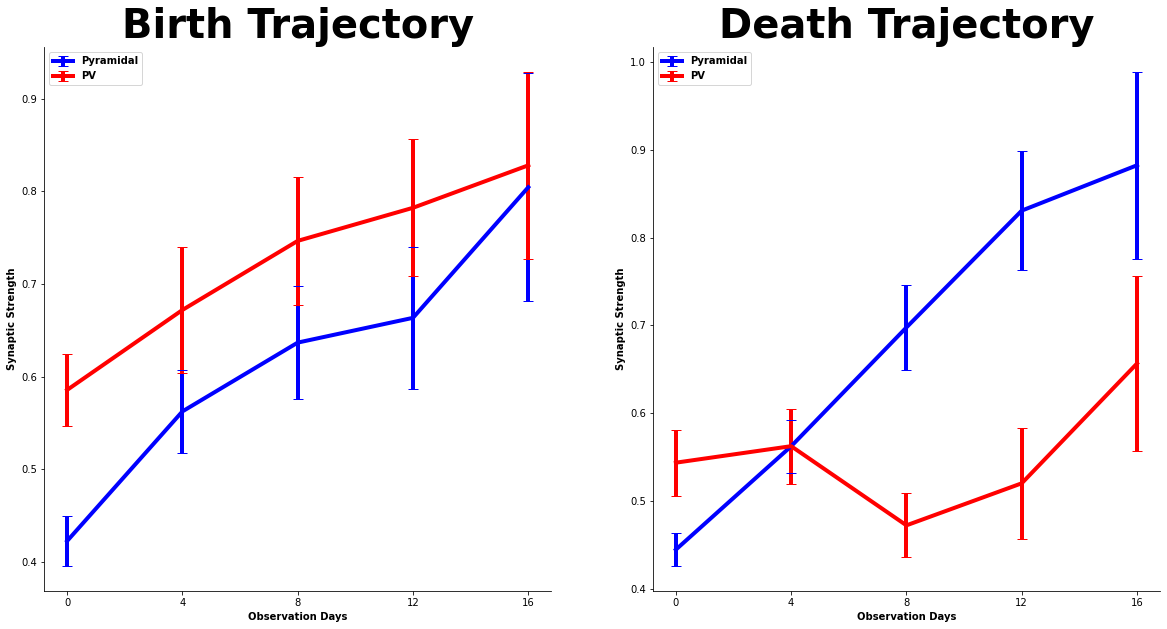

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

ax = plt.subplot(1, 2, 1)

Pyr_Control.plot_bta_dta(ax=ax, standalone_fig=False, mode="birth", label="Pyramidal", color="b")
PV_Control.plot_bta_dta(ax=ax, standalone_fig=False, mode="birth", label="PV", color="r")
plt.title('Birth Trajectory', weight='bold', size=40)

ax = plt.subplot(1, 2, 2)
Pyr_Control.plot_bta_dta(ax=ax, standalone_fig=False, mode="death", label="Pyramidal", color="b")
PV_Control.plot_bta_dta(ax=ax, standalone_fig=False, mode="death", label="PV", color="r")
plt.title('Death Trajectory', weight='bold', size=40)

plt.show()


# Figure 4A,B

Synaptic strengths over time

In [5]:
def get_survived_synapses(w, lower_percentile=25, higher_percentile=75, normalize=True, abs_val=True):
    survival = np.sum((w != 0).astype(int), axis=1)
    survival_idxs = np.where(survival == w.shape[1])[0]
    w_survive = w[survival_idxs]
    w_survive_first = w_survive[:, 0]
    w_lb = np.percentile(w_survive_first, lower_percentile)
    w_ub = np.percentile(w_survive_first, higher_percentile)
    interval_idxs = np.where((w_survive_first >= w_lb) & (w_survive_first <= w_ub))[0]
    w_ret = w_survive[interval_idxs]
    if normalize:
        w_ret = np.log(w_ret / np.expand_dims(w_ret[:, 0], axis=1))
    if abs_val:
        w_ret = np.abs(w_ret)
    return w_ret

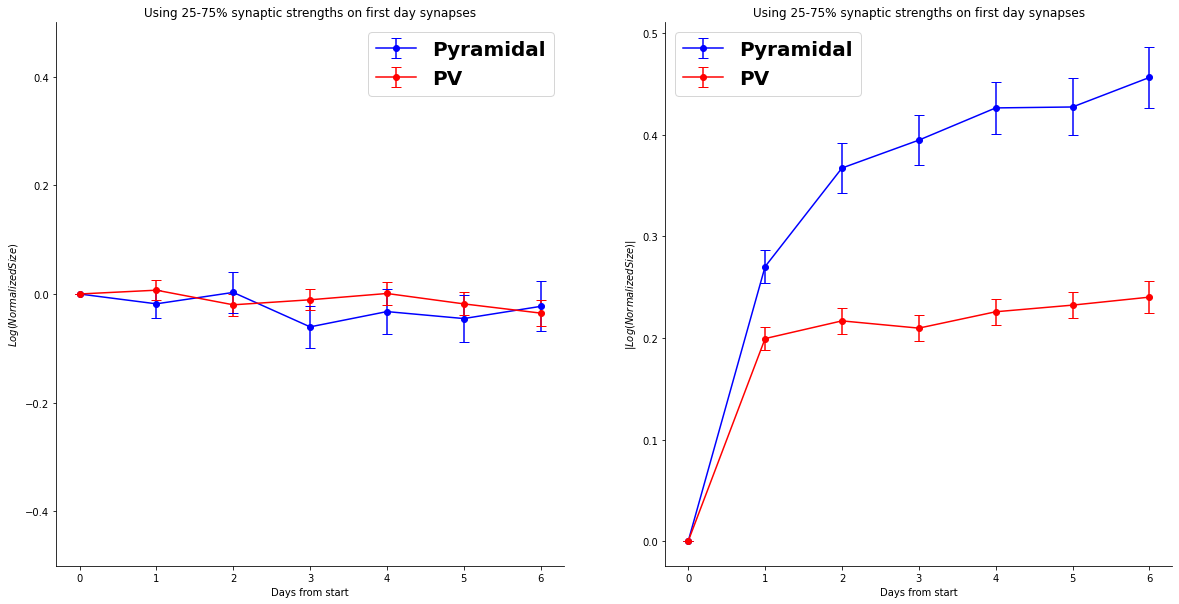

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
Pyr_survive = get_survived_synapses(Pyr_Control.weights,abs_val=False)
PV_survive = get_survived_synapses(PV_Control.weights,abs_val=False)
plt.errorbar(np.arange(7), np.mean(Pyr_survive[:, :7], axis=0), sem(Pyr_survive[:, :7], axis=0), 
             marker='o', capsize=5, color='b', label="Pyramidal")
plt.errorbar(np.arange(7), np.mean(PV_survive, axis=0), sem(PV_survive, axis=0), 
             marker='o', capsize=5, color='r', label="PV")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.legend(prop={'weight':'bold', 'size':20}, loc='best')
plt.title("Using 25-75% synaptic strengths on first day synapses")
plt.xlabel("Days from start")
plt.ylabel("$Log(Normalized Size)$")
plt.ylim(-.5,.5)

ax = plt.subplot(1, 2, 2)
Pyr_survive = get_survived_synapses(Pyr_Control.weights)
PV_survive = get_survived_synapses(PV_Control.weights)
plt.errorbar(np.arange(7), np.mean(Pyr_survive[:, :7], axis=0), sem(Pyr_survive[:, :7], axis=0), 
             marker='o', capsize=5, color='b', label="Pyramidal")
plt.errorbar(np.arange(7), np.mean(PV_survive, axis=0), sem(PV_survive, axis=0), 
             marker='o', capsize=5, color='r', label="PV")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.legend(prop={'weight':'bold', 'size':20}, loc='best')
plt.title("Using 25-75% synaptic strengths on first day synapses")
plt.xlabel("Days from start")
plt.ylabel("|$Log(Normalized Size)$|")

plt.show()